In [1]:
%load_ext autoreload
%autoreload 2

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import glob

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from adapters import *
from dataset import NumpyCsvDataSet
from runner import ExptRunner
from networks.autoencoder import AutoEncoder
from networks.composedautoencoder import ComposedAutoEncoder
from networks.DenseAutoEncoder import DenseAutoEncoder
from networks.ConvVae import ConvVae
from networks.vae import VAE
from networks.etpr.autoencoder import autoencoder as etprautoenc
from networks.dense import Dense
from networks.dense import DenseForPolicy
from networks.lossfunctions import *
from helpers import ReportResults
from policyeval import PolicyEvaluator

In [3]:
opt = np.get_printoptions()
np.set_printoptions(threshold=np.inf)

In [4]:
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
print (device)

cpu


In [5]:
start = time.time()
data_folder = 'data/demoplanner/version1'
v1_train_data = NumpyCsvDataSet(data_folder + '/train.csv', device=device)
v1_test_data = NumpyCsvDataSet(data_folder + '/test.csv', device=device)
print ("Time Taken: {} sec".format(time.time() - start))

Time Taken: 25.255686044692993 sec


In [6]:
start = time.time()
data_folder = 'data/demoplanner/version2'
v2_train_data = NumpyCsvDataSet(data_folder + '/train.csv', device=device)
v2_test_data = NumpyCsvDataSet(data_folder + '/test.csv', device=device)
print ("Time Taken: {} sec".format(time.time() - start))

Time Taken: 299.4014210700989 sec


In [7]:
test_data = v2_test_data.data
train_data = v2_train_data.data

In [8]:
print (train_data.shape)
print (test_data.shape)

print (train_data.device)
print (test_data.device)

torch.Size([129779, 2058])
torch.Size([6648, 2058])
cpu
cpu


In [9]:
t_cpu = test_data.data.cpu()
start_indices = []
index = 0
while index < len(t_cpu):
    start_indices.append(index)
    start, goal = t_cpu[index, :2], t_cpu[index, 2:4]
    index += int(max(np.abs(goal - start)))
print (start_indices)
print (len(start_indices))

[0, 22, 31, 34, 43, 50, 70, 86, 90, 106, 114, 122, 138, 152, 157, 173, 184, 191, 211, 219, 224, 226, 249, 260, 269, 279, 290, 307, 324, 340, 355, 367, 376, 400, 412, 426, 436, 453, 474, 485, 489, 509, 530, 536, 545, 554, 579, 597, 608, 621, 643, 651, 656, 664, 676, 683, 692, 706, 713, 740, 759, 774, 792, 802, 819, 841, 853, 878, 898, 905, 914, 925, 934, 944, 954, 974, 984, 998, 1007, 1008, 1015, 1025, 1043, 1061, 1065, 1089, 1094, 1103, 1114, 1126, 1129, 1152, 1160, 1177, 1183, 1196, 1207, 1232, 1243, 1265, 1274, 1293, 1302, 1316, 1328, 1350, 1358, 1371, 1375, 1397, 1402, 1422, 1439, 1442, 1454, 1461, 1481, 1500, 1516, 1536, 1550, 1559, 1565, 1577, 1601, 1626, 1645, 1669, 1681, 1694, 1702, 1720, 1729, 1738, 1753, 1777, 1792, 1793, 1794, 1802, 1814, 1818, 1836, 1842, 1865, 1887, 1909, 1915, 1925, 1931, 1941, 1963, 1979, 1998, 2023, 2042, 2068, 2093, 2096, 2106, 2124, 2136, 2149, 2160, 2180, 2194, 2206, 2213, 2236, 2242, 2248, 2260, 2269, 2291, 2304, 2312, 2322, 2336, 2350, 2360, 2380, 2

In [11]:
policy = Dense([4, 16, 16, 6], use_last_act=False)
policy.load_state_dict(torch.load('runs/04-08-10-24-50-Policy-V2-Dense-CE/autoenc.pth', map_location=device))

dynamics = Dense([4, 16, 2])
dynamics.load_state_dict(torch.load('runs/03-31-18-02-52-Dynamics-V1-Dense-SmoothL1/autoenc.pth', map_location=device))

<All keys matched successfully>

In [40]:
e = PolicyEvaluator(distance_func=F.l1_loss, policy=policy, dynamics=dynamics, 
                    using_grad_dynamics=True)

for i in range(len(start_indices)):
    rstart = start_indices[i]
    rend = start_indices[i+1] if i < len(start_indices)-1 else len(t_cpu)
    trajectory = t_cpu[rstart:rend, :]
    goal_err, step_err, _, _, _, _ = e.eval_single_trajectory(trajectory)
    print ('Tajectory {}: goal error = {}, average error = {}, length = {}'
           .format(i, goal_err, step_err, len(trajectory)))

Tajectory 0: goal error = 0.17319869995117188, average error = 0.08483083546161652, length = 22
Tajectory 1: goal error = 0.04053640365600586, average error = 0.022297488525509834, length = 9
Tajectory 2: goal error = 0.012553215026855469, average error = 0.00836197566241026, length = 3
Tajectory 3: goal error = 0.049368858337402344, average error = 0.022742006927728653, length = 9
Tajectory 4: goal error = 0.06147050857543945, average error = 0.03434460610151291, length = 7
Tajectory 5: goal error = 0.13530957698822021, average error = 0.057687193155288696, length = 20
Tajectory 6: goal error = 0.13261890411376953, average error = 0.06405003368854523, length = 16
Tajectory 7: goal error = 0.022810935974121094, average error = 0.012806415557861328, length = 4
Tajectory 8: goal error = 0.09192895889282227, average error = 0.040435582399368286, length = 16
Tajectory 9: goal error = 0.04153919219970703, average error = 0.0216066837310791, length = 8
Tajectory 10: goal error = 0.0636272430

Tajectory 104: goal error = 0.1506967544555664, average error = 0.06760384887456894, length = 22
Tajectory 105: goal error = 0.0660853385925293, average error = 0.0323907732963562, length = 8
Tajectory 106: goal error = 0.06023883819580078, average error = 0.03188140690326691, length = 13
Tajectory 107: goal error = 0.029360532760620117, average error = 0.016719043254852295, length = 4
Tajectory 108: goal error = 0.13202905654907227, average error = 0.05197051912546158, length = 22
Tajectory 109: goal error = 0.028837203979492188, average error = 0.01564178429543972, length = 5
Tajectory 110: goal error = 0.1988544464111328, average error = 0.11251430213451385, length = 20
Tajectory 111: goal error = 0.10505485534667969, average error = 0.04733756184577942, length = 17
Tajectory 112: goal error = 0.013987302780151367, average error = 0.009298483841121197, length = 3
Tajectory 113: goal error = 0.06390619277954102, average error = 0.03106015920639038, length = 12
Tajectory 114: goal err

Tajectory 191: goal error = 0.10987091064453125, average error = 0.05503099411725998, length = 14
Tajectory 192: goal error = 0.051670074462890625, average error = 0.02574305608868599, length = 10
Tajectory 193: goal error = 0.0872650146484375, average error = 0.038773439824581146, length = 15
Tajectory 194: goal error = 0.07918787002563477, average error = 0.03680197894573212, length = 13
Tajectory 195: goal error = 0.1374073028564453, average error = 0.060967303812503815, length = 22
Tajectory 196: goal error = 0.03466320037841797, average error = 0.018464088439941406, length = 5
Tajectory 197: goal error = 0.08252859115600586, average error = 0.037439361214637756, length = 16
Tajectory 198: goal error = 0.06383323669433594, average error = 0.03169097378849983, length = 12
Tajectory 199: goal error = 0.08132266998291016, average error = 0.041065264493227005, length = 19
Tajectory 200: goal error = 0.2129659652709961, average error = 0.10927080363035202, length = 25
Tajectory 201: goa

Tajectory 282: goal error = 0.14103031158447266, average error = 0.06085686385631561, length = 25
Tajectory 283: goal error = 0.07345771789550781, average error = 0.03439708426594734, length = 12
Tajectory 284: goal error = 0.1248009204864502, average error = 0.05694127827882767, length = 21
Tajectory 285: goal error = 0.05390787124633789, average error = 0.02504110336303711, length = 10
Tajectory 286: goal error = 0.08563649654388428, average error = 0.04267002269625664, length = 19
Tajectory 287: goal error = 0.08675289154052734, average error = 0.03940638527274132, length = 17
Tajectory 288: goal error = 0.18218004703521729, average error = 0.0799320787191391, length = 24
Tajectory 289: goal error = 0.095794677734375, average error = 0.04909129813313484, length = 12
Tajectory 290: goal error = 0.10339951515197754, average error = 0.044464364647865295, length = 16
Tajectory 291: goal error = 0.06157493591308594, average error = 0.02960370108485222, length = 13
Tajectory 292: goal err

Tajectory 368: goal error = 0.0663442611694336, average error = 0.030380595475435257, length = 11
Tajectory 369: goal error = 0.07803201675415039, average error = 0.03933323919773102, length = 18
Tajectory 370: goal error = 0.13968515396118164, average error = 0.06632253527641296, length = 15
Tajectory 371: goal error = 0.12830734252929688, average error = 0.05490676313638687, length = 20
Tajectory 372: goal error = 0.08032941818237305, average error = 0.044272568076848984, length = 18
Tajectory 373: goal error = 0.07976055145263672, average error = 0.03599216043949127, length = 15
Tajectory 374: goal error = 0.08218669891357422, average error = 0.03703572228550911, length = 13
Tajectory 375: goal error = 0.1015009880065918, average error = 0.04991545155644417, length = 21
Tajectory 376: goal error = 0.13173675537109375, average error = 0.06222166493535042, length = 26
Tajectory 377: goal error = 0.06415510177612305, average error = 0.03157522901892662, length = 9
Tajectory 378: goal e

Tajectory 469: goal error = 0.0786433219909668, average error = 0.03556254878640175, length = 15
Tajectory 470: goal error = 0.04276609420776367, average error = 0.02191072702407837, length = 8
Tajectory 471: goal error = 0.10491180419921875, average error = 0.04861701279878616, length = 15
Tajectory 472: goal error = 0.07915806770324707, average error = 0.030999334529042244, length = 11
Tajectory 473: goal error = 0.09106826782226562, average error = 0.04318083077669144, length = 13
Tajectory 474: goal error = 0.06384944915771484, average error = 0.031417686492204666, length = 9
Tajectory 475: goal error = 0.017471790313720703, average error = 0.01032749842852354, length = 3
Tajectory 476: goal error = 0.02136850357055664, average error = 0.012891292572021484, length = 3
Tajectory 477: goal error = 0.16514194011688232, average error = 0.0726119801402092, length = 16
Tajectory 478: goal error = 0.03882741928100586, average error = 0.02128582075238228, length = 5
Tajectory 479: goal err

In [41]:
traj_no = 58
rstart = start_indices[traj_no]
rend = start_indices[traj_no+1] if traj_no < len(start_indices) else len(test_data)
trajectory = t_cpu[rstart:rend, :]
f = torch.cat((trajectory[:, :4], trajectory[:, 1028:1030]), dim=1)
print (len(f))
print (f)

27
tensor([[29.,  2.,  2., 23., -1.,  0.],
        [28.,  2.,  2., 23., -1.,  0.],
        [27.,  2.,  2., 23., -1.,  0.],
        [26.,  2.,  2., 23., -1.,  0.],
        [25.,  2.,  2., 23., -1.,  0.],
        [24.,  2.,  2., 23., -1.,  0.],
        [23.,  2.,  2., 23., -1.,  1.],
        [22.,  3.,  2., 23., -1.,  1.],
        [21.,  4.,  2., 23., -1.,  1.],
        [20.,  5.,  2., 23., -1.,  1.],
        [19.,  6.,  2., 23., -1.,  1.],
        [18.,  7.,  2., 23., -1.,  1.],
        [17.,  8.,  2., 23., -1.,  1.],
        [16.,  9.,  2., 23., -1.,  1.],
        [15., 10.,  2., 23., -1.,  1.],
        [14., 11.,  2., 23., -1.,  1.],
        [13., 12.,  2., 23., -1.,  1.],
        [12., 13.,  2., 23., -1.,  1.],
        [11., 14.,  2., 23., -1.,  1.],
        [10., 15.,  2., 23., -1.,  1.],
        [ 9., 16.,  2., 23., -1.,  1.],
        [ 8., 17.,  2., 23., -1.,  1.],
        [ 7., 18.,  2., 23., -1.,  1.],
        [ 6., 19.,  2., 23., -1.,  1.],
        [ 5., 20.,  2., 23., -1.,  1.

In [48]:
goal_err, step_err, pred_traj, orig_traj, policy_pred, dyn_pred = e.eval_single_trajectory(trajectory)

print ('Last step error = {}'.format(goal_err))
print ('Average error over all steps = {}'.format(step_err))
print ('Original Trajectory and Predicted Trajectory:')
print (torch.cat((orig_traj, pred_traj), dim=1))
print ('Stepwise deviation from original trajectory:')
print (torch.abs(orig_traj-pred_traj))
print ('Prediction from Policy:')
print (policy_pred - 1.0) # Using minus to bring the policy output to the values we expect
print ('Prediction from Dynamics:')
print (dyn_pred * 2.0 - 1.0)  # Again bringing the dynamics prediction to the expected range

Last step error = 0.27548301219940186
Average error over all steps = 0.12676073610782623
Original Trajectory and Predicted Trajectory:
tensor([[28.0000,  2.0000, 28.0088,  1.9995],
        [27.0000,  2.0000, 27.0176,  1.9990],
        [26.0000,  2.0000, 26.0264,  1.9987],
        [25.0000,  2.0000, 25.0352,  1.9984],
        [24.0000,  2.0000, 24.0441,  1.9982],
        [23.0000,  2.0000, 23.0529,  1.9980],
        [22.0000,  3.0000, 22.0651,  2.9860],
        [21.0000,  4.0000, 21.0772,  3.9740],
        [20.0000,  5.0000, 20.0893,  4.9621],
        [19.0000,  6.0000, 19.1013,  5.9501],
        [18.0000,  7.0000, 18.1134,  6.9382],
        [17.0000,  8.0000, 17.1253,  7.9262],
        [16.0000,  9.0000, 16.1372,  8.9143],
        [15.0000, 10.0000, 15.1491,  9.9024],
        [14.0000, 11.0000, 14.1609, 10.8905],
        [13.0000, 12.0000, 13.1727, 11.8786],
        [12.0000, 13.0000, 12.1845, 12.8667],
        [11.0000, 14.0000, 11.1961, 13.8548],
        [10.0000, 15.0000, 10.2078, 1

In [8]:
map_netname_net = {
    'ComposedAutoEncoderWithMaxPool': lambda: ComposedAutoEncoder(useMaxPool=True),
    'DenseAutoEncoder3': lambda: DenseAutoEncoder(enc_layer_dims=[1024, 128, 16]),
    'ComposedAutoEncoderNoMaxPool': lambda: ComposedAutoEncoder(useMaxPool=False),
    'VAE': VAE,
    'ConvVAE': ConvVae,
    'EtprEncoder': etprautoenc,
    '03-31-18-02-15-Dynamics-V1-Dense-SmoothL1': lambda: Dense([4, 2]),
    '03-31-18-02-32-Dynamics-V1-Dense-SmoothL1': lambda: Dense([4, 8, 2]),
    '03-31-18-02-52-Dynamics-V1-Dense-SmoothL1': lambda: Dense([4, 16, 2]),
    '03-31-18-01-03-Dynamics-V1-Dense-MSE': lambda: Dense([4, 2]),
    '03-31-18-01-22-Dynamics-V1-Dense-MSE': lambda: Dense([4, 8, 2]),
    '03-31-18-01-50-Dynamics-V1-Dense-MSE': lambda: Dense([4, 16, 2]),
}     

In [11]:
rr = ReportResults(map_netname_net, device, 
                   dynamics_input_adapter, dynamics_gradient_ground_truth_adapter,
                   loss_adapter_func = l1_loss_adapter)

In [12]:
rr.generate_csv_comparison_report(test_data_float, train_data_float,
                   rootdir='runs/03-31')

Time,Goal,DataSet,Network,Loss(Training),TestLoss,TrainLoss
03:31:18:01:03,Dynamics,V1,Dense,MSE,0.0821070447564125,0.08388315141201019
03:31:18:01:22,Dynamics,V1,Dense,MSE,0.003344212891533971,0.0034352901857346296
03:31:18:01:50,Dynamics,V1,Dense,MSE,0.003786794375628233,0.003730030497536063
03:31:18:02:15,Dynamics,V1,Dense,SmoothL1,0.07136806100606918,0.07271932810544968
03:31:18:02:32,Dynamics,V1,Dense,SmoothL1,0.005948166828602552,0.006144481245428324
03:31:18:02:52,Dynamics,V1,Dense,SmoothL1,0.0032131331972777843,0.0033073569647967815


In [13]:
sample = torch.cat((test_data_float[1055:1060], test_data_float[1230:1235]), axis=0)
ground_truth = dynamics_gradient_ground_truth_adapter(sample).to(device)
for folder, net in rr.build_net(rootdir='runs/03-31/'):
    print ('Folder: ' + folder)
    op_batch, loss = rr.run_mini_batch(net, sample)
    print (ground_truth)
    print (op_batch)
    print (loss)
    print ('-----------------------------------------')

Folder: 03-31-18-01-03-Dynamics-V1-Dense-MSE
tensor([[0.0000, 0.5000],
        [0.0000, 0.0000],
        [0.0000, 0.5000],
        [0.0000, 0.5000],
        [0.0000, 0.5000],
        [1.0000, 0.0000],
        [1.0000, 0.0000],
        [1.0000, 0.0000],
        [1.0000, 0.0000],
        [1.0000, 0.5000]])
tensor([[0.1214, 0.5738],
        [0.1264, 0.1509],
        [0.0993, 0.4931],
        [0.1002, 0.4953],
        [0.1011, 0.4974],
        [0.9014, 0.1185],
        [0.9010, 0.1189],
        [0.9006, 0.1193],
        [0.9003, 0.1197],
        [0.9171, 0.5654]], grad_fn=<SigmoidBackward>)
tensor(0.0904, grad_fn=<MeanBackward0>)
-----------------------------------------
Folder: 03-31-18-01-22-Dynamics-V1-Dense-MSE
tensor([[0.0000, 0.5000],
        [0.0000, 0.0000],
        [0.0000, 0.5000],
        [0.0000, 0.5000],
        [0.0000, 0.5000],
        [1.0000, 0.0000],
        [1.0000, 0.0000],
        [1.0000, 0.0000],
        [1.0000, 0.0000],
        [1.0000, 0.5000]])
tensor([[0.0047, 0

In [19]:
rr = ReportResults(map_netname_net, device, 
                   policy_input_adapter, policy_groud_truth_adapter,
                   loss_adapter_func = l1_loss_adapter)

In [20]:
rr.generate_csv_comparison_report(test_data_float, train_data_float,
                   rootdir='runs/04-08')

Time,Goal,DataSet,Network,Loss(Training),TestLoss,TrainLoss
04:08:07:35:53,Policy,V2,Dense,MSE,0.0009246765985153615,0.0009788279421627522
04:08:07:29:36,Policy,V2,Dense,MSE,0.015583701431751251,0.016864705830812454


In [21]:
sample = torch.cat((test_data_float[1055:1060], test_data_float[1230:1235]), axis=0)
ground_truth = policy_groud_truth_adapter(sample).to(device)
for folder, net in rr.build_net(rootdir='runs/04-08/'):
    print ('Folder: ' + folder)
    op_batch, loss = rr.run_mini_batch(net, sample)
    print (ground_truth)
    print (op_batch)
    print (loss)

Folder: 04-08-07-35-53-Policy-V2-Dense-MSE
tensor([[-1.,  0.],
        [-1., -1.],
        [-1.,  0.],
        [-1.,  0.],
        [-1.,  0.],
        [ 1., -1.],
        [ 1., -1.],
        [ 1., -1.],
        [ 1., -1.],
        [ 1.,  0.]])
tensor([[-1.0000e+00, -5.9831e-04],
        [-9.9837e-01, -9.9866e-01],
        [-1.0000e+00, -2.0846e-03],
        [-1.0000e+00, -2.0014e-03],
        [-1.0000e+00, -1.9175e-03],
        [ 9.9764e-01, -9.9867e-01],
        [ 9.9765e-01, -9.9868e-01],
        [ 9.9766e-01, -9.9868e-01],
        [ 9.9767e-01, -9.9868e-01],
        [ 1.0000e+00,  7.1299e-04]], grad_fn=<TanhBackward>)
tensor(0.0012, grad_fn=<MeanBackward0>)
Folder: 04-08-07-29-36-Policy-V2-Dense-MSE
tensor([[-1.,  0.],
        [-1., -1.],
        [-1.,  0.],
        [-1.,  0.],
        [-1.,  0.],
        [ 1., -1.],
        [ 1., -1.],
        [ 1., -1.],
        [ 1., -1.],
        [ 1.,  0.]])
tensor([[-0.9994, -0.0311],
        [-0.9682, -0.9674],
        [-0.9995,  0.0176],
   

datapoint 0 test error tensor(9.2288e-06)


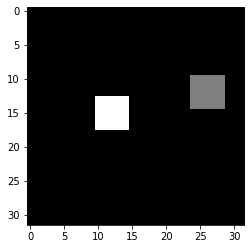

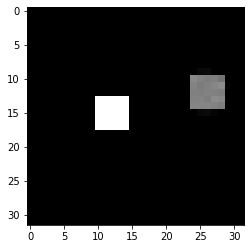

datapoint 1 test error tensor(9.4870e-06)


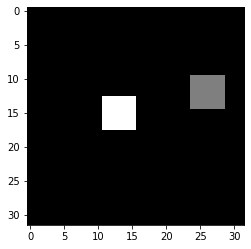

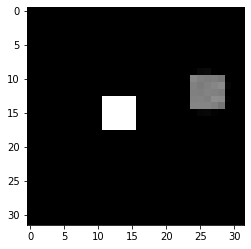

datapoint 2 test error tensor(1.5805e-05)


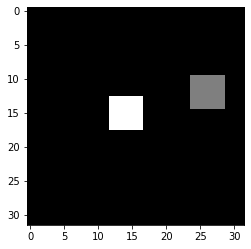

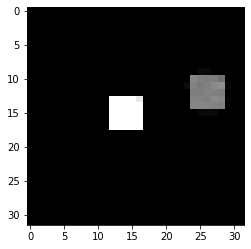

datapoint 3 test error tensor(1.1305e-05)


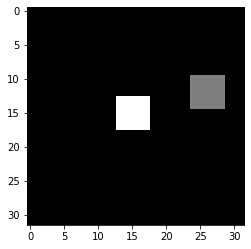

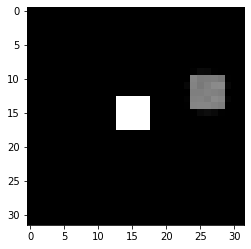

datapoint 4 test error tensor(1.3016e-05)


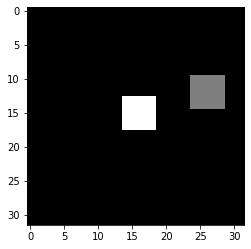

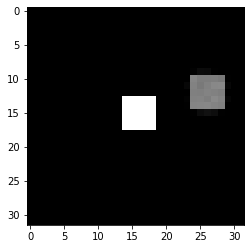

In [16]:
rr.show_test_samples(test_data_float,
                  rootdir='runs/03-28/03-28-14-10-20-DemoPl-V2-ComposedAutoEncoderWithMaxPool-SmoothL1-')

In [ ]:
np.set_printoptions(**opt)